In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
import torch, sys
print("Torch version:", torch.__version__)
print("Torch CUDA:", torch.version.cuda)
print("Python exe:", sys.executable)


Torch version: 2.5.1+cu121
Torch CUDA: 12.1
Python exe: e:\final year project\justifi-legal-ai\legal_env\Scripts\python.exe


In [3]:

import numpy as np

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


e:\final year project\justifi-legal-ai\legal_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "law-ai/InLegalBERT"

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    use_safetensors=True,     
    trust_remote_code=True
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at law-ai/InLegalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
train_file = r"E:\final year project\justifi-legal-ai\datasets\binary_single_train\CJPE_ext_SCI_HCs_Tribunals_daily_orders_single.csv"
dev_file   = r"E:\final year project\justifi-legal-ai\datasets\binary_dev\CJPE_ext_SCI_HCs_Tribunals_daily_orders_dev.csv"
test_file  = r"E:\final year project\justifi-legal-ai\datasets\binary_test\CJPE_ext_SCI_HCs_Tribunals_daily_orders_test.csv"


In [6]:

dataset = load_dataset(
    "csv",
    data_files={
        "train": train_file,
        "validation": dev_file,
        "test": test_file
    },
    streaming=True
)

In [7]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

In [8]:
tokenized_train = dataset["train"].map(tokenize_function)
tokenized_val   = dataset["validation"].map(tokenize_function)


In [9]:
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_val   = tokenized_val.remove_columns(["text"])

tokenized_train = tokenized_train.with_format("torch")
tokenized_val   = tokenized_val.with_format("torch")

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

In [11]:
training_args = TrainingArguments(
    output_dir="./inlegalbert_results",

    max_steps=4500,              # 🔽 not 5000

    eval_strategy="steps",
    eval_steps=1000,             # 🔽 less frequent eval
    save_steps=1000,

    learning_rate=2e-5,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,

    weight_decay=0.01,
    logging_steps=200,

    load_best_model_at_end=True,
    metric_for_best_model="f1",

    fp16=True,
    report_to="none"
)


In [12]:
import transformers
print(transformers.__version__)


4.57.3


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\vikas\AppData\Local\Temp\ipykernel_14692\846229407.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1000,0.655900,0.633647,0.626442,0.633243,0.573250,0.601755
2000,0.619400,0.604806,0.656552,0.642549,0.681543,0.661472
3000,0.591500,0.593764,0.669992,0.695799,0.585813,0.636086
4000,0.577500,0.581732,0.678850,0.700534,0.607301,0.650594


TrainOutput(global_step=4500, training_loss=0.6196174714830187, metrics={'train_runtime': 7589.8593, 'train_samples_per_second': 9.486, 'train_steps_per_second': 0.593, 'total_flos': 1.894399598592e+16, 'train_loss': 0.6196174714830187, 'epoch': 1.0})

In [15]:
results = trainer.evaluate()
results


{'eval_loss': 0.604806125164032,
 'eval_accuracy': 0.6565522693452381,
 'eval_precision': 0.6425486441960907,
 'eval_recall': 0.6815434022858222,
 'eval_f1': 0.6614718217862627,
 'eval_runtime': 1215.2606,
 'eval_samples_per_second': 35.39,
 'eval_steps_per_second': 8.847,
 'epoch': 1.0}

In [16]:
trainer.save_model("inlegalbert_final")
tokenizer.save_pretrained("inlegalbert_final")


('inlegalbert_final\\tokenizer_config.json',
 'inlegalbert_final\\special_tokens_map.json',
 'inlegalbert_final\\vocab.txt',
 'inlegalbert_final\\added_tokens.json',
 'inlegalbert_final\\tokenizer.json')

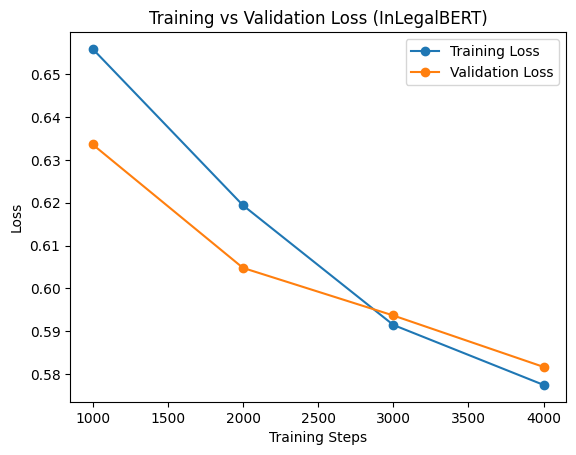

In [17]:
import matplotlib.pyplot as plt

steps = [1000, 2000, 3000, 4000]
train_loss = [0.6559, 0.6194, 0.5915, 0.5775]
val_loss   = [0.6336, 0.6048, 0.5937, 0.5817]

plt.figure()
plt.plot(steps, train_loss, marker='o', label='Training Loss')
plt.plot(steps, val_loss, marker='o', label='Validation Loss')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (InLegalBERT)")
plt.legend()
plt.show()


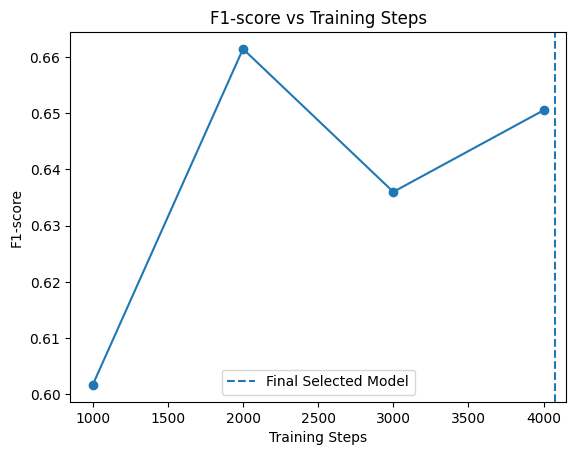

In [20]:
steps = [1000, 2000, 3000, 4000]
f1_scores = [0.6017, 0.6614, 0.6360, 0.6505]

plt.figure()
plt.annotate("Best Checkpoint",
             xy=(2000, 0.665),
             xytext=(2200, 0.67),
             arrowprops=dict(arrowstyle="->"))

plt.plot(steps, f1_scores, marker='o')
plt.axvline(x=4074, linestyle='--', label='Final Selected Model')
plt.xlabel("Training Steps")
plt.ylabel("F1-score")
plt.title("F1-score vs Training Steps")
plt.legend()
plt.show()



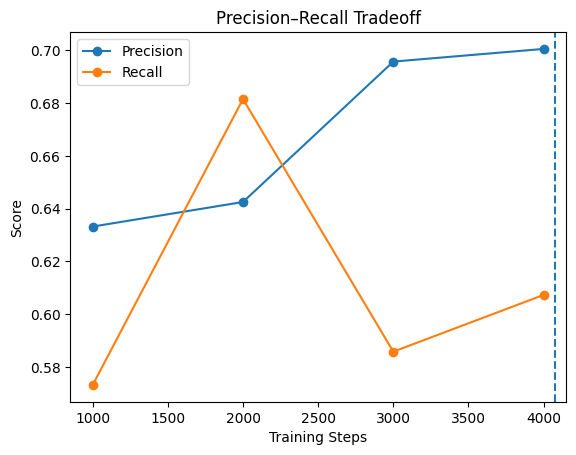

In [21]:
precision = [0.6332, 0.6425, 0.6957, 0.7005]
recall    = [0.5732, 0.6815, 0.5858, 0.6073]

plt.figure()
plt.plot(steps, precision, marker='o', label='Precision')
plt.plot(steps, recall, marker='o', label='Recall')
plt.axvline(x=4074, linestyle='--')
plt.xlabel("Training Steps")
plt.ylabel("Score")
plt.title("Precision–Recall Tradeoff")
plt.legend()
plt.show()


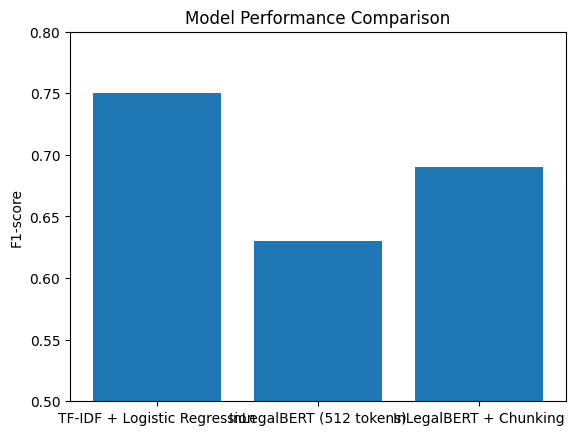

In [22]:
models = [
    "TF-IDF + Logistic Regression",
    "InLegalBERT (512 tokens)",
    "InLegalBERT + Chunking"
]

f1 = [0.75, 0.63, 0.69]

plt.figure()
plt.bar(models, f1)
plt.ylabel("F1-score")
plt.title("Model Performance Comparison")
plt.ylim(0.5, 0.8)
plt.show()


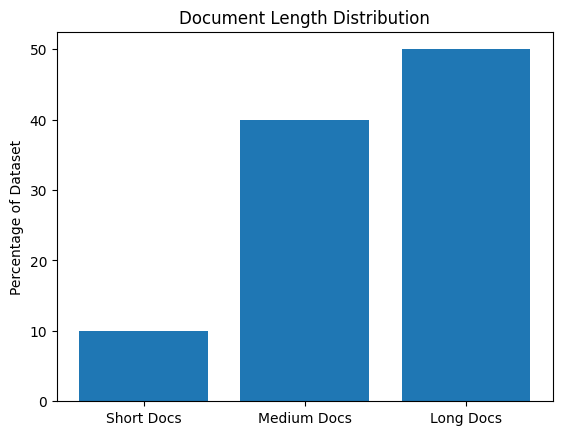

In [23]:
doc_types = ["Short Docs", "Medium Docs", "Long Docs"]
percentage = [10, 40, 50]

plt.figure()
plt.bar(doc_types, percentage)
plt.ylabel("Percentage of Dataset")
plt.title("Document Length Distribution")
plt.show()
